In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Predicting Diabetes

## Problem Statement & Dataset

I found a dataset from https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset which comprises of medical and demographic information about patients and their diabetes status. The data consists of several features: age, gender, body mass index (BMI), hypertension, heart disease, smoking history, HbA1c level, and blood glucose level. The dataset can be useful in a variety of domains including healthcare and medical research to explore how different features correalate to one's diabetes status or to accurately diagonse patients who have diabetes. However, for my project, the target audience is the common public that wants to know if they have diabetes or if they are at a significant high risk of devloping diabetes. The main goal is to not achieve 100% accuracy similar to what a healthcare establishment would require but rather the goal is to make people aware of their likelihood of developing diabetes and provide them with a background of how their lifestyle would be influencing this likelihood as well as aim to provide positive amendements to their lifestyle to reduce/reverse their diabeties likelihood. Therefore, the goal is to achieve a more healtheir lifestyle amongst the common public which means maximizing the accuracy of predicting more accurately people who have diabetes or are close to developing it with diabetes so they can make positive changes to their lifestyle. Since our goal is to create awarenss amongst the society about diabetes and their lifestyle, our goal is to maximize predicitng peeople who have diabetes accurately and those that do not, we would not loose much by predicting inaccurately as this is model is not for a healthcare establishment but rather for maximizing positive amendements to people's lifestyle through increasing their attention towards the risk of developing diabetes.

In [56]:
diabetes = pd.read_csv('diabetes_data.csv')

In [57]:
diabetes.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [58]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [59]:
# no info = null entries
diabetes.loc[diabetes['smoking_history'] == 'No Info','smoking_history'] = None

In [60]:
diabetes.shape

(100000, 9)

In [61]:
diabetes.isnull().sum()

gender                     0
age                        0
hypertension               0
heart_disease              0
smoking_history        35816
bmi                        0
HbA1c_level                0
blood_glucose_level        0
diabetes                   0
dtype: int64

The data has 100000 entries with 35816 null entries

## Exploratory data analysis

Let's first try to understand and get a better idea of our audience and if possible to narrow it, to produce more effective impact as well as look for important relations between diagnosis of diabetes and other features:

In [62]:
#let's drop the missing values
diabetes.dropna(inplace=True)

In [63]:
diabetes.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [64]:
diabetes.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
5,Female,20.0,0,0,never,27.32,6.6,85,0


In [65]:
diabetes['gender'].value_counts()

Female    38852
Male      25320
Other        12
Name: gender, dtype: int64

Since the size of data collected for genders in the other category is too small, we would drop their data as it would be unfair to evalue based on other gender when there are simply not enough data record to draw conclusions and compare to the other two genders that have a signifcant higher number of data entries. 

In [66]:
diabetes = diabetes[diabetes['gender'] != 'Other']

In [67]:
diabetes['gender'].value_counts()

Female    38852
Male      25320
Name: gender, dtype: int64

Text(0.5, 1.0, 'Number of Patients with(out) Diabetes by Gender')

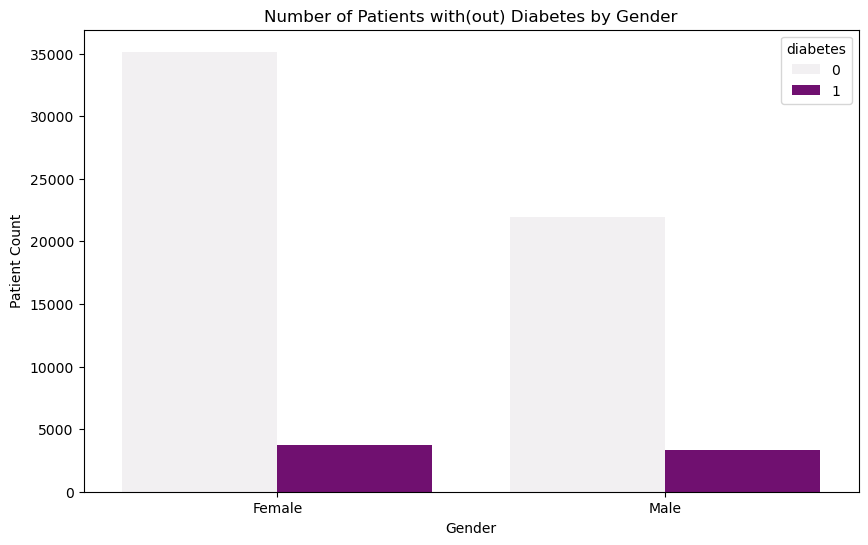

In [68]:
#check distirbution by gender
plt.figure(figsize=(10, 6))
sns.countplot(x='gender', hue='diabetes', data=diabetes, color = 'purple')
plt.xlabel('Gender')
plt.ylabel('Patient Count')
plt.title('Number of Patients with(out) Diabetes by Gender')

As seen from the graph above, the number of people diagnosed with diabetes is similar for both females and males. The graph is not skewed towards any sepecifc gender. Therefore, there is no apparent correlation between gender and being diagnosed with diabetes.

Text(0.5, 1.0, 'Number of Patients with(out) Diabetes by Age')

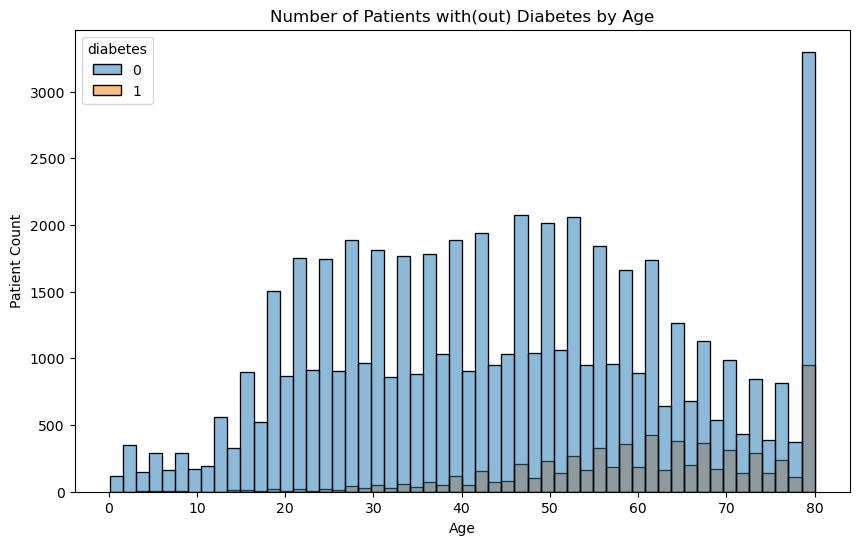

In [69]:
#check distirbution by age
plt.figure(figsize=(10, 6))
sns.histplot(x='age', hue='diabetes', data=diabetes)
plt.xlabel('Age')
plt.ylabel('Patient Count')
plt.title('Number of Patients with(out) Diabetes by Age')

As seen from the graph above, as the age increases, the number of patients with diabetes increases substantially. There are almost zero patients with diabetes from ages 0-30. However, there are is large number between ages 60-80, the maximum count being around the age 80. This helps us direct more of our focus towards the older public who is at a higher risk of devloping diabetes and would mostly benefit with changes to their lifestyle. 

Text(0.5, 1.0, 'Number of Patients with(out) Diabetes by Hypertension')

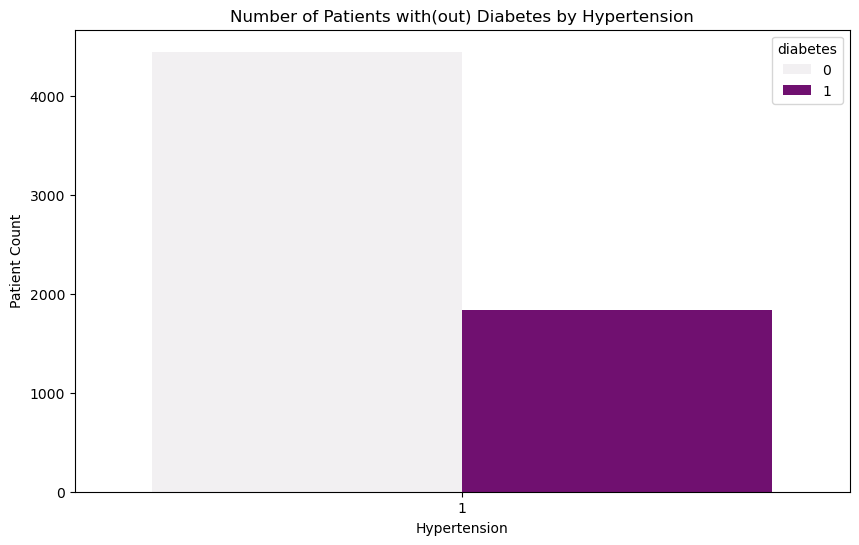

In [70]:
#check for the relation between hypertension and diabetes
plt.figure(figsize=(10, 6))
sns.countplot(x='hypertension', data=diabetes[diabetes['hypertension']==1], hue = 'diabetes',color='purple')
plt.xlabel('Hypertension')
plt.ylabel('Patient Count')
plt.title('Number of Patients with(out) Diabetes by Hypertension')

From the graph above, we can see the number of people with hypertension are more for people without diabetes. This suggests rather a negative correlation between hypertension and diabetes. However, the number of people with both diabetes and hypertension are not negligible, almost half of the ones with both diabets and hypertension. Since hypertension is already a dangerous condition for health, some data about people who have diabetes are not very far off from those that have hypertension can cause people to care more about their diabetes status.

Text(0.5, 1.0, 'Number of Patients with(out) Diabetes by Heart Disease')

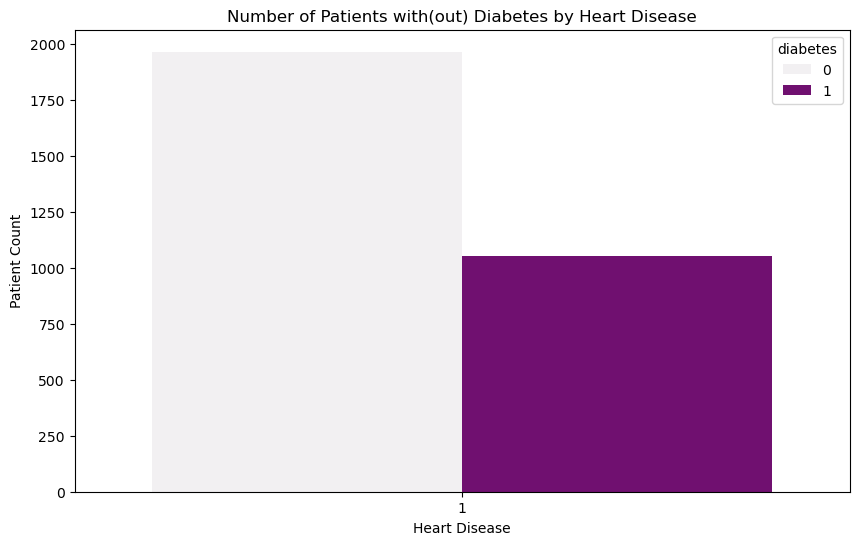

In [71]:
#check for relation between heart disease patients and diabtes
plt.figure(figsize=(10, 6))
sns.countplot(x='heart_disease', data=diabetes[diabetes['heart_disease']==1], hue = 'diabetes',color='purple')
plt.xlabel('Heart Disease')
plt.ylabel('Patient Count')
plt.title('Number of Patients with(out) Diabetes by Heart Disease')

From the count plot above, we can see there are much less people with both diabetes and heart disease, similar to the pattern with the hypertension patients. However, the number of people with both heart disease and diabetes are much more than those with hypertension and diabetes. Since heart diseases are at quite alot of times fatal, using the data from the graph above we can subtancially increase attention towards diabetes of the common public by showing how the stats of people with both diabetes and heart diseases are not far off with those with just heart disease, more so with the heart disease data than the hypertension data. 

Now, that we have a relatievely better idea of the audience, let's look at the key features affecting the presence of diabetes. For that, we would need to specifically look at the diabetic patients. 

In [72]:
#mostly interested in the features impacting diabetes
diabetics=diabetes[diabetes['diabetes']==1]

Text(0.5, 1.0, 'Number of Patients with(out) Diabetes by Smoking History')

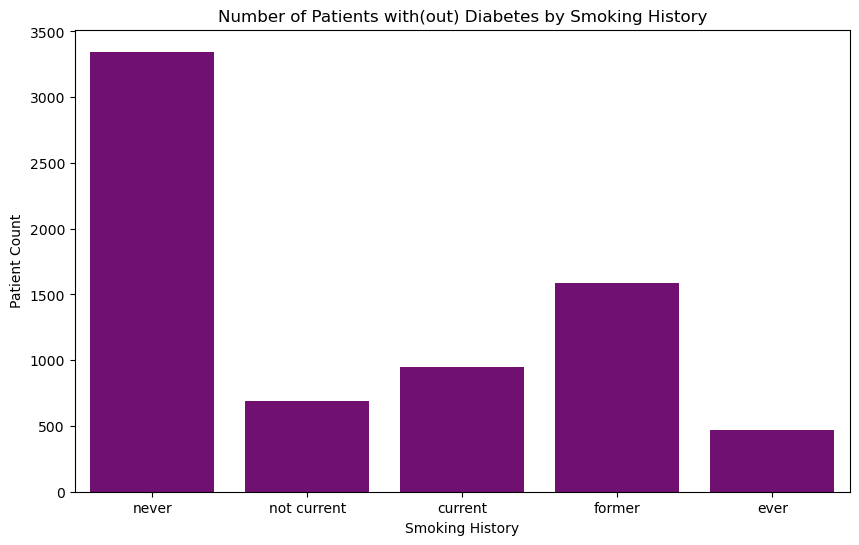

In [73]:
#how does smoking history relate to diabetes
plt.figure(figsize=(10, 6))
sns.countplot(x='smoking_history', data=diabetics, color = 'purple')
plt.xlabel('Smoking History')
plt.ylabel('Patient Count')
plt.title('Number of Patients with(out) Diabetes by Smoking History')

From the plot above, most people diabetes have not smoked before. Therefore, there is no set correlation between smoking and diabetes, even though the act of smoking is generally harmful to health. This might perhaps explain why alot of diabetic people (second highest count after people who have never smoked) were former smokers, and have stopped smoking after being diagnosed. Even though smoking negatively impacts health, it does not specifically impact diabetes. However, diabetic people most likely do have a misconception of how smoking affects their diabetic health, which can be cleared through these figures. 

Text(0.5, 1.0, 'Number of Patients with Diabetes by BMI')

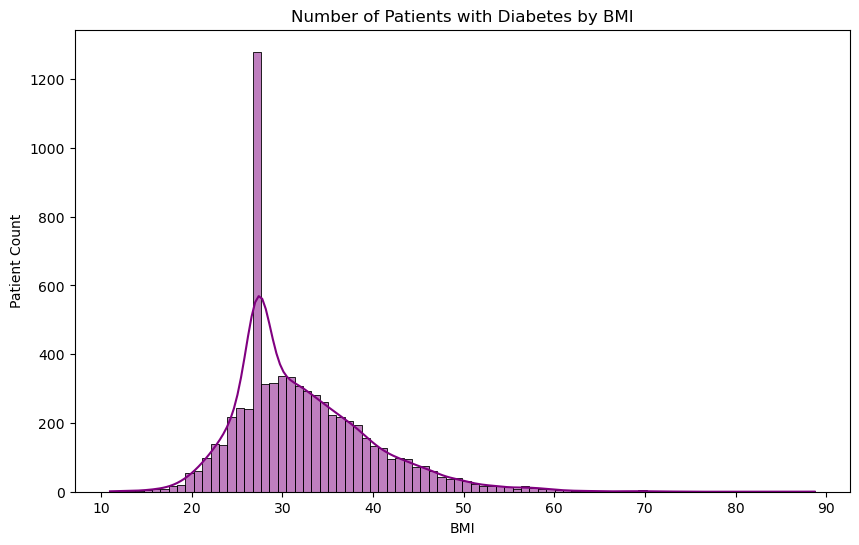

In [74]:
#relation between BMI and diabetes
plt.figure(figsize=(10, 6))
sns.histplot(diabetics['bmi'], kde=True, color = 'purple')
plt.xlabel('BMI')
plt.ylabel('Patient Count')
plt.title('Number of Patients with Diabetes by BMI')

From the histogram above, it is clear that the majority of the people with diabtes have a BMI close to 27-28 which is a little above the average healthy BMI (25). Additonally, the graph is skewed towards the right, indicating most diabetic people have a higher BMI which means a more unhealthier body weight. Perhaps there needs to be a greater focus on reducing body weight, and hence BMI to reduce the risk of developing diabetes. Let's confirm the relation of BMI with age so we can be sure of what to focus on (reducing BMI) and who to focus on (age group) at the same time. 

Text(0.5, 1.0, 'Variation of BMI with Age for Diabetics')

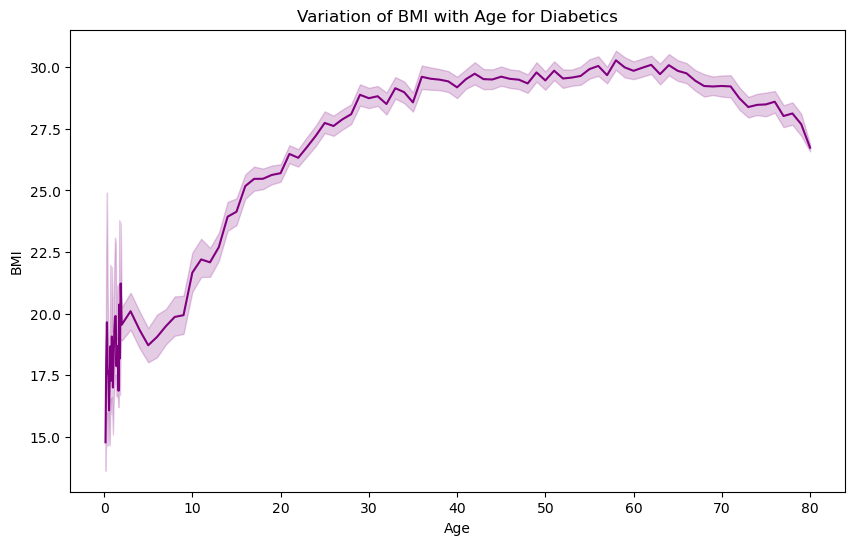

In [75]:
#check if BMI increases with ages
plt.figure(figsize=(10, 6))
sns.lineplot(diabetes,x='age',y='bmi',color='purple')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.title('Variation of BMI with Age for Diabetics')

The graph above futher consolidates our direction (to target older peoppe) as the BMI significantky increases with age. The approach to take would be suggest specifc diet improvements for older people, age 30+. 

Text(0.5, 0, 'HBA1c levels')

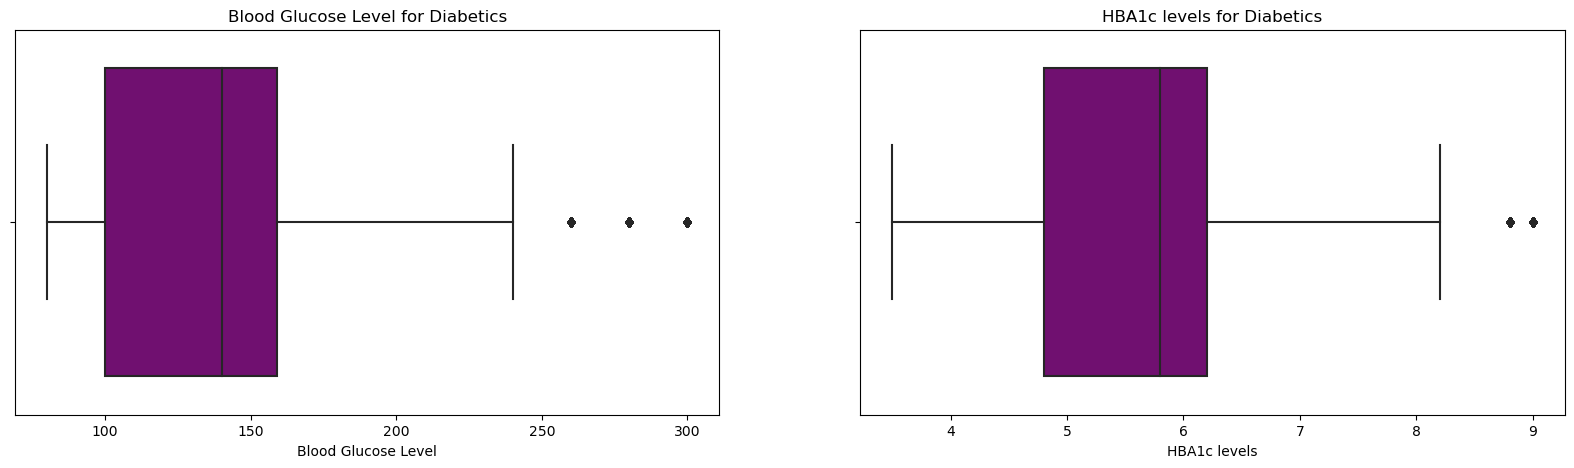

In [76]:
#box plot of glucose and HBA1c levels for diabetic patients (a medical reference for people)
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=diabetes,x='blood_glucose_level',hue='diabetes',color='purple')
plt.title('Blood Glucose Level for Diabetics')
plt.xlabel('Blood Glucose Level')

plt.subplot(1, 2, 2)
sns.boxplot(data=diabetes,x='HbA1c_level',hue='diabetes',color='purple')
plt.title('HBA1c levels for Diabetics')
plt.xlabel('HBA1c levels')

From the plots above, the median blood glucose level lies around 140 while the maximum likes around 240 for diabetic patients. Addtionally, the median HBA1c level lies around 5.9 while the maximum likes around 8.1 for diabetic patients. Even though blood glucose and HBA1c levels are medical measurement and would not be easily accesible to the common public, this reference will aid people, in the case they do get these tests done, in comparing where their medical readings lie in comparison to people with diabetic and approximately what risk are they at with respect to devloping diabeties.

## Modeling

In [77]:
#define X and y (what are we predicting)
X = diabetes.drop('diabetes',axis=1)
y = diabetes['diabetes']

In [78]:
#split the data to start for our models
from sklearn.model_selection import train_test_split

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

Since our objective is to predict diabetes for people, this is a classification problem, our output is either positive(1) or negative(0). Therefore, to build a predictive model, using a linear regression model would not be suitable as the linear model makes predictions based on linear and continuous data. We would be exploring three different models that are more helpful for our classifier model: KNN classifer, Logistic regression, and Decision Tree.

In [85]:
#we want to incoporate as much fetaures to give a more accurate model so we will encode the categorical features and let the rest pass through using the column transformer 
from sklearn.compose import make_column_transformer

In [86]:
ohe = OneHotEncoder(sparse = False, drop = 'if_binary')

In [87]:
encoder = make_column_transformer((ohe, ['gender','smoking_history']), 
                                  verbose_feature_names_out=False,
                                  remainder='passthrough')

In [88]:
X_train_encoded = encoder.fit_transform(X_train)

/Users/fatimafarooq/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [89]:
X_test_encoded = encoder.transform(X_test)

We will use a grid search obeject to search for the best parameters for our KNN mode

In [90]:
# parameters we want to try
params = {'n_neighbors': range(1, 30, 2)}

In [91]:
# estimator with parameters
knn = KNeighborsClassifier()

In [92]:
grid = GridSearchCV(knn, param_grid=params, cv =5)

In [93]:
grid.fit(X_train_encoded, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 30, 2)})

In [94]:
grid.best_estimator_

KNeighborsClassifier(n_neighbors=7)

The grid object allows us to conclude that the model with 7 neighbors yielded the best results

In [95]:
grid.score(X_test_encoded,y_test)

0.9405348126908932

In [96]:
#compare to baseline
y_train.value_counts(normalize = True)

0    0.890129
1    0.109871
Name: diabetes, dtype: float64

Looking at the KNN model individually, it performed better than the baseline. If we predicted everyone to not have diabetes, we would be correct 89.0% of the times, but with our model, we are right 94.1% of the time. This is not signifcantly better than the baseline but still better. However, we care more so about how many diabetic people were not predicted diabetes. Since our goal is to create awarenss amongst the society about diabetes and their lifestyle, our goal is to maximize predicitng peeople who have diabetes accurately and those that do not, we would not loose much by predicting inaccurately as this is model is not for a healthcare establishment but rather for maximizing positive amendements to people's lifestyle through increasing their attention towards the risk of developing diabetes. Hence, we would look at the confusion matrix for all our models later to evaluate which is the best one. 

Now, we would try the logistic regression model: 

In [97]:
lr = LogisticRegression()

In [98]:
pipe_lr = Pipeline([('encoder', encoder), ('model', lr)])

In [99]:
pipe_lr.fit(X_train,y_train)

/Users/fatimafarooq/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/fatimafarooq/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse=False),
                                                  ['gender',
                                                   'smoking_history'])],
                                   verbose_feature_names_out=False)),
                ('model', LogisticRegression())])

In [100]:
print("Score on train data")
print(pipe_lr.score(X_train,y_train))
print("Score on test data")
print(pipe_lr.score(X_test,y_test))

Score on train data
0.9448980863928192
Score on test data
0.9475783830954311


The logistic model performed close to the KNN model with an accuracy of 94.8%, however the logisitic model has an advantage over the KNN model that we can see the weightage each feature carries on prediciting the outcome by looking at the coeficients of the features which we would explore in interpreting which features matter more in predicitng diabeties. 

Now, we would try the decision tree:

In [101]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [102]:
#selecting the best tree
train_scores = []
test_scores = []
for d in range(1, 20):
    dtree = DecisionTreeClassifier(criterion = 'entropy',
                                 max_depth = d).fit(X_train_encoded, y_train)
    train_scores.append(dtree.score(X_train_encoded, y_train))
    test_scores.append(dtree.score(X_test_encoded, y_test))

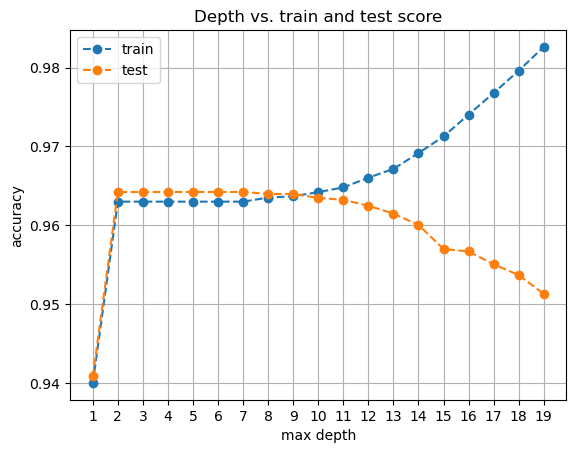

In [103]:
#plotting the results
plt.plot(range(1, 20), train_scores, '--o', label = 'train')
plt.plot(range(1, 20), test_scores, '--o', label = 'test')
plt.grid()
plt.legend()
plt.xticks(range(1, 20))
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.title('Depth vs. train and test score');

As seen from the graph above, the maximum score on the test data is reached starting at depth 2 onwards till depth 7, after which its start decreasing. We would select depth two as with this depth we can use the minimal power creating the model as well as maximize accuracy

In [104]:
dtree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 2).fit(X_train_encoded, y_train)

[Text(0.6, 0.8333333333333334, 'HbA1c_level <= 6.7\nentropy = 0.5\nsamples = 48129\nvalue = [42841, 5288]\nclass = no diabetes'),
 Text(0.4, 0.5, 'blood_glucose_level <= 210.0\nentropy = 0.34\nsamples = 45728\nvalue = [42841, 2887]\nclass = no diabetes'),
 Text(0.2, 0.16666666666666666, 'entropy = 0.242\nsamples = 44622\nvalue = [42841, 1781]\nclass = no diabetes'),
 Text(0.6, 0.16666666666666666, 'entropy = 0.0\nsamples = 1106\nvalue = [0, 1106]\nclass = diabetes'),
 Text(0.8, 0.5, 'entropy = 0.0\nsamples = 2401\nvalue = [0, 2401]\nclass = diabetes')]

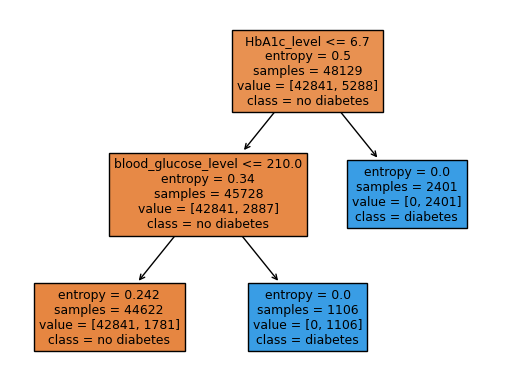

In [105]:
#visualize the tree:
plot_tree(dtree, feature_names = encoder.get_feature_names_out().tolist(), class_names=['no diabetes','diabetes'],filled=True)

The KNN classifier predicts that everyone with HbA1c level greater than 6.7 and blood glucose level greater than 210 is diagnosed with diabetes. It is important that both these features are medical and are not readily available to most people. More oftenly, people would need to go to a healthcare professional to get these measurements. 

In [106]:
dtree.score(X_train_encoded,y_train)

0.9629952835089032

In [107]:
dtree.score(X_test_encoded,y_test)

0.9642211556442062

The decision tree model performed better than both of the other models, with an accuray of 96.4%. In order to actually reach a conclusion about which is the best model for our objective, we would look at the confusion matrix for our models

Text(0.5, 1.0, 'KNN')

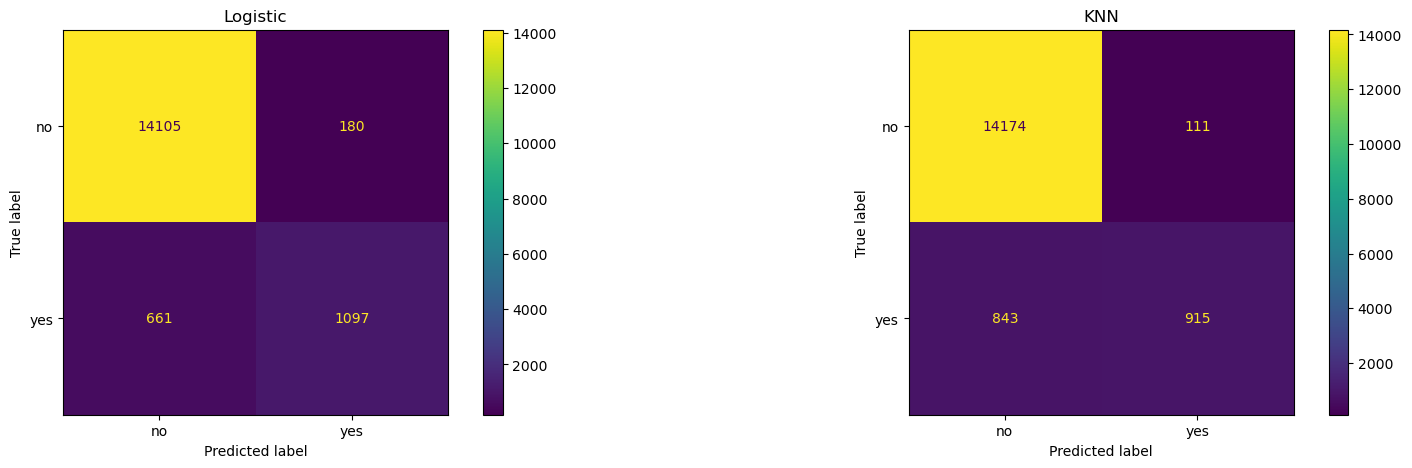

In [108]:
# compare knn and logistic
fig, ax = plt.subplots(1, 2, figsize = (20, 5))
ConfusionMatrixDisplay.from_estimator(pipe_lr, X_test, y_test, display_labels=['no', 'yes'], ax = ax[0])
ax[0].set_title('Logistic')
ConfusionMatrixDisplay.from_estimator(grid, X_test_encoded, y_test, display_labels=['no', 'yes'], ax = ax[1])
ax[1].set_title('KNN')

<Figure size 2000x500 with 0 Axes>

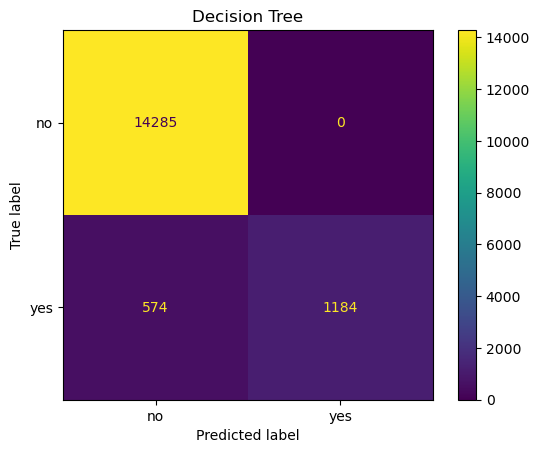

In [109]:
plt.figure(figsize=(20, 5))
ConfusionMatrixDisplay.from_estimator(dtree, X_test_encoded, y_test, display_labels=['no', 'yes'])
plt.title('Decision Tree');

Since we want to majorly reduce the number of wrong predictions for diabetics, we would look at the bottom left sqaure in each of the matrices. For the logistic regression model, we predicted wrong 661 times, 843 times in the KNN model, and only 574 times in the decison tree model. For our purpose, the decision tree model seems most suitable as it has the lest number of wring predictions for diabetics. However, logistic regression is not far off. Both these models deem acceptable in our case. Choosing one over the other would now depend on which model allows us to draw most information and better interpret what features are integral in predicting diabeties. The KNN model has a much greater number of wrong predcitions, hence we would be ignoring it. 

## Interpretation

The two models that performed the best were the logistic regression and the desision tree. Fortunately, both of these models allow us to delve into how much each feature matters in deciding a prediction for diabetes. We do this by looking at the coefficients of our models

In [113]:
coefs = pipe_lr.named_steps['model'].coef_
feature_names = pipe_lr.named_steps['encoder'].get_feature_names_out()

In [114]:
coefs
#cannot just compare them as they are, need to multiply standard deviation with the coefs

array([[ 0.49128755, -4.13110983, -3.32899374, -3.99426185, -3.78586969,
        -3.83539322,  0.03382858,  0.48736943,  2.50515238,  0.07458499,
         1.88217759,  0.03060216]])

In [115]:
coef_df = pd.DataFrame(coefs*X_train_encoded.std(),columns = feature_names)
coef_df = coef_df.T

In [116]:
coef_df

,0
gender_Male,20.348748
smoking_history_current,-171.107352
smoking_history_ever,-137.884328
smoking_history_former,-165.439215
smoking_history_never,-156.807774
smoking_history_not current,-158.859000
age,1.401153
hypertension,20.186462
heart_disease,103.761460
bmi,3.089252


According to the above dataframe, we can see that the feature that impacted our diabetes prediction the most was wheather you have a heart disease and your HbA1c_level, follwed by your gender being male and having hypertension. With respect to our objective, this allows us to target our lifestyle awareness to more heart disease patients. Previously, we were focused on just looking at older people, however now we realize we can focus more on raising awareness about the probabable risk of devloping diabetes amongst heart disease patients. Additionally, HbA1c level also contributes significatly towards a positive diabetes prediction. When we start off any campaigns on lifestyle changes, or ask for medical information from people for our objective, or give out suggestions, it is impertaive we focus on these two features and aim to reverse them for reducing the risk of devloping diabetes. Additionally, when we suggest out lifestyle changes, we should source our sugegstions from the point of reducing heart diseases and HbA1c levels as that would bring about the most significant impact to one's future diabetes status. Additionally, when we were exploring our data earlier, there was no apparent trend according to gender and hypertension pateints, however, now we can see how being a male and having hypertension slightly increases your chance of devloping diabetes. This knowledge can be utilized when there is a need to narrow down various heart disease patients to those being male and/or having hypertension.

In [117]:
#looking at features that mattered the most in our decision tree model
pd.DataFrame({'features': encoder.get_feature_names_out(), 'importance': dtree.feature_importances_})

,features,importance
0,gender_Male,0.000000
1,smoking_history_current,0.000000
2,smoking_history_ever,0.000000
3,smoking_history_former,0.000000
4,smoking_history_never,0.000000
5,smoking_history_not current,0.000000
6,age,0.000000
7,hypertension,0.000000
8,heart_disease,0.000000
9,bmi,0.000000


According to our decison tree model, only two features were deemed most important and the rest were ignored since our tree stopped at a depth of 2. Those two features were HbA1c level and the blood glucose level. HbA1c level has a greater importance and also corresponds to one of the features that mattered greatly in our logistic model. The important takeaway is to focus most on HbA1c level, even though it is a very sophisticated medical data, it allows one to greatly guage on where they stand on the spectrum of developing diabetes. HbA1c level should be minimized amongst people and there needs to more awareness amongst people on how to reduce this and hence mitigate great chances of devloping diabetes. Suggestions for lifestyle modifications should foremostly stem for how to reduce HbA1c levels. 

## Next steps and discussion:

#### Next step:

My next step is to make the model public in part of a bigger campaign to give out people positive suggestions to improve their lifestyle. I would ensure the public is aware that the objective of the prediction is not to cause panic but rather to increase awareness of one's diabetic status. If one is detected diabetes, the first step is to go to a healthcare establishment and get through with proper diabetic medical examinations. If it confirms our prediction, this helps you to start with the right course of medicines. If, however, it contradicts with our prediction, you can breathe a sigh of relief but at the same time also acknolwedge that your lifestyle may be causing you at a higher risk of diabetes, therefore your next step would be to try to benefit from the advice sent out from the campaign

#### Summary:
My objective was to increase awareness regarding diabetes and help people make positve amendmeents in lifestyle through my prospective campaign suggestions. This project helped me better understand my audeience audience and acheive a coomprehsnive approach on how to target them. 
Here are they key takeaways: 
1. Focus the audeince to more older people
2. Emphasize focus on heart disease patients
3. Suggestions should be concentrate with suggestions/ways to reduce heart disease and Hb1Ac levlels 
4. Urge people to get few medical measurements (mainly HbA1c level and blood glucose level)
5. Secondary way to narrow down audeince even more: focus slightly more on the male gender
6. Look at hypertension patients as well, perhaps more so for people who already have a reduced risk of heart disease (information collected from their information given to the model for prediction) and give out specific suggestions on how lifetsyle changes can decrease hypertension

#### Ways to improve:
The exploration of the dataset and the subsequeent models that were built through this project helped the campaign develop a comprehsnive and detailed approach of tackling an aim/objective. Instead of basing decisions on mere guessing and hypothesis, the analysis done in this project helps us back our reasoning with strong statistics. Given the immense benefit of the data exploration and model building, our aim should always be to further improve our models to retrive the absolute best outcomes. Here are a few ways I see to improve my data exploration and modeling: 
1. Increase dataset, for example include more data entries for the other categories in gender
2. Add more gerogrpahical data and phsycial activity so we can make an even more comprehnsive analysis 
3. Try more different classification models
4. Have a model that gives out a probability of devloping diabetes instead of just predicting a positive or negative, perhaps a  probalistic classifier model
5. Diversify our dataset, to ensure that it includes different regions so our predictions are not biased to a specific region
6. Have another model with just medical features and another with just everyday features, this gives us flexibility to choose the model according to our input (we want to optimize results based on input)
7. Test out the models and make them public and then ask for feedbcak from people and incorproate it into rebuilding or changing paramters of the models (as this model is primarily for the public and for their benefit)
